In [1]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pypfopt.cla import CLA
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
import yfinance as yf

sys.path.append('..')
from util.batcher import Batcher
#from util.stock_loader import Loader

In [2]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
START, TODAY

(datetime.date(2012, 6, 13), datetime.date(2022, 6, 11))

In [3]:
sharpes = pd.read_csv('sharpes.csv')
sharpes.head()

,stock,sharpe
0,ASAN,4.146624
1,efc,3.530101
2,lly,3.048137
3,eve,2.531150
4,chmt,2.475858


<a href="https://www.advfn.com/nyse/newyorkstockexchange.asp?companies=M">NYSE listings</a>

In [6]:
KEEP_TOP_N = 50
sym = (
    'mye myov nabl nc ncr ngl nl nov dnow nrg nvr netc nbr ntp nbhc nfg '
    'ngg nhi npk nnn nruc nsa ntco ngs ngvc ntz nls nsh nci nvgs nna nm '
    'nav np nni nptn nrdy nsco ntst  nbxg nvro hyb nfc nfh gci gf irl '
    'njr newm nmfc nmfx newr nrz snr nyc nycb nyt neu nct nem nr nxe '
    'nxdt nref nxrt nhf nex nexa nee nep kind nimc nic nlsn nke nine ntt'
)
missing = (
    'nfc nfh nsh nsco newm ntt snr nmfx nci nna nhf nav'
)
SYMBOLS = [s for s in sym.split() if s not in missing.split()]
#SYMBOLS

In [7]:
data = (
    yf.download(SYMBOLS, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
data.columns = SYMBOLS
data.head()

[*********************100%***********************]  65 of 65 completed


,mye,myov,nabl,nc,ncr,ngl,nl,nov,dnow,nrg,...,nex,nexa,nee,nep,kind,nimc,nic,nlsn,nke,nine
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-13,NaN,NaN,4.189929,4.446069,3.711406,NaN,12.382722,NaN,NaN,NaN,...,13.25,30.0,768.119995,NaN,5.995008,NaN,NaN,NaN,6.583622,5.917367
2012-06-14,NaN,NaN,4.205934,4.441705,3.672080,NaN,12.397657,NaN,NaN,NaN,...,12.85,30.0,789.919983,NaN,6.053783,NaN,NaN,NaN,6.648969,6.056055
2012-06-15,NaN,NaN,4.237942,4.450434,3.686827,NaN,12.352844,NaN,NaN,NaN,...,13.40,30.0,783.210022,NaN,6.098112,NaN,NaN,NaN,6.719761,6.167005
2012-06-18,NaN,NaN,4.228340,4.467885,3.667164,NaN,12.532088,NaN,NaN,NaN,...,14.40,30.0,798.849976,NaN,5.979896,NaN,NaN,NaN,6.703426,6.305693
2012-06-19,NaN,NaN,4.295558,4.472248,3.745816,NaN,13.211722,NaN,NaN,NaN,...,15.40,30.0,802.940002,NaN,6.019300,NaN,NaN,NaN,6.741543,6.444380


In [8]:
def get_daily_returns(x):
    n = len(x)
    x = np.array(x)
    return x[2:n] / x[1:(n - 1)] - 1 

In [9]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [10]:
new_sharpes = []
for stock in SYMBOLS:
    sharpe = get_sharpe(get_daily_returns(data[stock]))
    new_sharpes.append([stock, sharpe])
    
sharpe_df = (
    pd.DataFrame(new_sharpes, columns=['stock', 'sharpe'])
    .sort_values('sharpe', ascending=False))
sharpe_df.head(15)

,stock,sharpe
18,npk,1.016337
15,nfg,0.940524
30,nni,0.933940
51,nxe,0.905256
61,nic,0.876764
33,ntst,0.745943
60,nimc,0.736004
29,np,0.724824
57,nee,0.703584
64,nine,0.690234


In [11]:
sharpes = (
    pd.concat([sharpes, sharpe_df])
    .sort_values('sharpe', ignore_index=True, ascending=False)
    .drop_duplicates())
sharpes.head(20)

,stock,sharpe
0,ASAN,4.146624
1,efc,3.530101
2,lly,3.048137
3,eve,2.531150
4,chmt,2.475858
5,hhs,2.406309
6,bxsl,2.249160
7,APSG,2.178348
8,dwin,1.886962
9,irs,1.757207


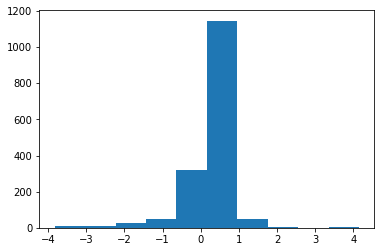

In [12]:
plt.hist(sharpes.sharpe);

In [13]:
sharpes.loc[sharpes.stock == 'CBX', :]

,stock,sharpe


In [14]:
omit = ('eg')
inds = []
for o in omit.split():
    inds += (sharpes.loc[sharpes.stock == o, :].index.tolist())

sharpes.drop(index=inds, inplace=True)

In [15]:
sharpes.to_csv('sharpes.csv', index=False)

In [16]:
sharpes.shape

(1632, 2)

In [17]:
MIX = sharpes.stock.unique().tolist()[:200]
len(MIX)
df = yf.download(MIX, start=START, end=TODAY)
df.drop(
    columns=['Open', 'Close', 'Volume', 'High', 'Low'], inplace=True)
print(df.shape)
df.head()

[*********************100%***********************]  200 of 200 completed
(2517, 200)


Adj Close                                                     \
                  ABC      ABEV        ABM ACA      ACRE ADCT        ADM   
Date                                                                       
2012-06-13  31.091248  4.227693  16.476713 NaN  7.589503  NaN  23.782125   
2012-06-14  31.526262  4.323909  16.857441 NaN  7.589503  NaN  23.782125   
2012-06-15  31.807743  4.325368  16.598221 NaN  7.797674  NaN  23.926674   
2012-06-18  32.251301  4.388054  16.654930 NaN  7.598178  NaN  23.804951   
2012-06-19  32.447479  4.560078  16.841240 NaN  7.515777  NaN  22.937654   

                                    ...                                   \
                 AEG       AEL AFI  ... NXE RERE SAVN SUNY TCS       TFG   
Date                                ...                                    
2012-06-13  2.594815  9.413962 NaN  ... NaN  NaN  NaN  NaN NaN  4.011414   
2012-06-14  2.633447  9.650220 NaN  ... NaN  NaN  NaN  NaN NaN  4.011414   
2012-06-15  2.794416  9.568439 NaN  ... NaN  NaN  NaN  NaN NaN  4.198038   
2012-06-18  2.736467  9.550265 NaN  ... NaN  NaN  NaN  NaN NaN  4.221200   
2012-06-19  2.871680  9.841044 NaN  ... NaN  NaN  NaN  NaN NaN  4.142097   

                                            
                   UAN       VLT WNNR XPOA  
Date                                        
2012-06-13  107.924477  7.453009  NaN  NaN  
2012-06-14  108.507576  7.514973  NaN  NaN  
2012-06-15  106.758316  7.435308  NaN  NaN  
2012-06-18  111.688049  7.399899  NaN  NaN  
2012-06-19  117.465919  7.461860  NaN  NaN  

[5 rows x 200 columns]

In [18]:
df.columns = MIX
MAX_MISSING = 30
n_nan = df.isnull().sum()
n_nan
drop = n_nan[n_nan > MAX_MISSING].index
df = df.drop(columns=drop)
print(df.shape)
df.head()

(2517, 111)


,ASAN,efc,lly,chmt,bxsl,APSG,dwin,iff,cm,AZEK,...,cxw,fsly,tcs,xpoa,AEL,fpl,fif,eqgp,dk,hcp
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-13,31.091248,4.227693,16.476713,7.589503,23.782125,2.594815,9.413962,15.940650,55.202881,59.141575,...,19.531393,19.809732,8.516503,8.664017,31.981451,18.595848,35.900341,4.011414,107.924477,7.453009
2012-06-14,31.526262,4.323909,16.857441,7.589503,23.782125,2.633447,9.650220,15.751120,56.019821,60.053562,...,19.772089,19.671095,8.440772,8.688309,32.349823,18.578764,36.728230,4.011414,108.507576,7.514973
2012-06-15,31.807743,4.325368,16.598221,7.797674,23.926674,2.794416,9.568439,15.701242,56.486668,60.888119,...,19.824924,20.380621,8.399995,8.712601,32.887634,18.928984,36.970142,4.198038,106.758316,7.435308
2012-06-18,32.251301,4.388054,16.654930,7.598178,23.804951,2.736467,9.550265,15.870825,57.203575,61.378521,...,19.871885,20.209352,8.429123,8.761184,32.983402,18.536055,36.298157,4.221200,111.688049,7.399899
2012-06-19,32.447479,4.560078,16.841240,7.515777,22.937654,2.871680,9.841044,16.249889,57.512035,61.843109,...,19.912985,21.041212,8.458248,8.898836,33.815903,19.245039,37.346466,4.142097,117.465919,7.461860


In [19]:
mu = mean_historical_return(df)
s = CovarianceShrinkage(df).ledoit_wolf()
ef = EfficientFrontier(mu, s)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
for k, v in dict(cleaned_weights).items():
    if v > 0:
        print(f'{k:6s}: {v}')

AZEK  : 0.05108
mmi   : 0.02798
inaq  : 0.00529
gnw   : 0.12916
gbab  : 0.01696
esus  : 0.05526
hae   : 0.07175
mov   : 0.00068
ASGN  : 0.07542
kmpr  : 0.00092
bv    : 0.05083
gl    : 0.00158
cnm   : 0.024
bxp   : 0.18171
kar   : 0.07132
mplx  : 0.03149
eqgp  : 0.20457


In [20]:
_, _, s1 = ef.portfolio_performance(verbose=True)

Expected annual return: 19.1%
Annual volatility: 12.7%
Sharpe Ratio: 1.34


In [21]:
s1

1.340941806588644

In [22]:
cla = CLA(mu, s)
min_vol_w = cla.min_volatility()
cleaned_weights = cla.clean_weights()
for k, v in dict(cleaned_weights).items():
    if v > 0:
        print(f'{k:6s}: {v}')

clr   : 0.00855
dhi   : 0.00847
ARCH  : 0.00938
gnw   : 0.00933
evg   : 0.02846
lyv   : 0.00647
hae   : 0.02625
fvrr  : 0.14126
ASGN  : 0.03302
lub   : 0.1229
kmpr  : 0.01034
RERE  : 0.001
culp  : 0.00015
bv    : 0.0353
ADCT  : 0.0523
chn   : 0.06039
bxp   : 0.00551
ANTM  : 0.00147
mfa   : 0.03447
tcs   : 0.13891
fif   : 0.02919
eqgp  : 0.20163
hcp   : 0.03524


In [24]:
r, v, s = cla.portfolio_performance(verbose=True)

Expected annual return: 7.1%
Annual volatility: 8.3%
Sharpe Ratio: 0.61


In [25]:
r, v, s

(0.07094017318328112, 0.08287145027356582, 0.6146890517195391)